In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision

import torch.nn.functional as F
from torch import nn
from torchvision import transforms as T
from torchinfo import summary
from torchvision.transforms.functional import to_pil_image
from torchvision.io.image import read_image
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from torchmetrics import JaccardIndex

import os, cv2, sys
from pathlib import Path
from PIL import Image
import random
from typing import Tuple, Dict, List


pd.options.mode.chained_assignment = None  # default='warn'
torch.set_printoptions(precision=4)
np.set_printoptions(threshold=5000)
torch.set_printoptions(threshold=5000)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
data_path = Path("kaggle")
train_path = data_path / "train"
val_path = data_path / "valid"
test_path = data_path / "test"

In [4]:
#lets read in the csv files that came with the dataset
class_dict = pd.read_csv(os.path.join(data_path, 'class_dict.csv'))
class_dict

,name,r,g,b
0,road,255,255,255
1,background,0,0,0


In [5]:
class_names = class_dict.name.tolist()
class_rgb_vals = class_dict[['r','g','b']].values.tolist()

print('The dataset has corresponding labels and rgb values:')
print(f"class names: {class_names}")
print(f"rgb values: {class_rgb_vals}")

The dataset has corresponding labels and rgb values:
class names: ['road', 'background']
rgb values: [[255, 255, 255], [0, 0, 0]]


In [6]:
metadata = pd.read_csv('kaggle/metadata.csv')
metadata['sat_image_path'] = metadata['sat_image_path'].apply(lambda sat_path: data_path / sat_path)

metadata

,image_id,split,sat_image_path,mask_path
0,100034,train,kaggle\train\100034_sat.jpg,train/100034_mask.png
1,100081,train,kaggle\train\100081_sat.jpg,train/100081_mask.png
2,100129,train,kaggle\train\100129_sat.jpg,train/100129_mask.png
3,100703,train,kaggle\train\100703_sat.jpg,train/100703_mask.png
4,100712,train,kaggle\train\100712_sat.jpg,train/100712_mask.png
...,...,...,...,...
8565,998829,test,kaggle\test\998829_sat.jpg,NaN
8566,998928,test,kaggle\test\998928_sat.jpg,NaN
8567,999518,test,kaggle\test\999518_sat.jpg,NaN
8568,999651,test,kaggle\test\999651_sat.jpg,NaN


In [7]:
metadata.split.unique() #get names of the data splits

array(['train', 'valid', 'test'], dtype=object)

In [8]:
#lets manipulate the metadata df to split into tran/val/test

metadata_train = metadata.loc[metadata['split'] == 'train']
metadata_train['mask_path'] = metadata_train['mask_path'].apply(lambda maskpath: data_path / maskpath)

metadata_train

,image_id,split,sat_image_path,mask_path
0,100034,train,kaggle\train\100034_sat.jpg,kaggle\train\100034_mask.png
1,100081,train,kaggle\train\100081_sat.jpg,kaggle\train\100081_mask.png
2,100129,train,kaggle\train\100129_sat.jpg,kaggle\train\100129_mask.png
3,100703,train,kaggle\train\100703_sat.jpg,kaggle\train\100703_mask.png
4,100712,train,kaggle\train\100712_sat.jpg,kaggle\train\100712_mask.png
...,...,...,...,...
6221,999431,train,kaggle\train\999431_sat.jpg,kaggle\train\999431_mask.png
6222,999531,train,kaggle\train\999531_sat.jpg,kaggle\train\999531_mask.png
6223,999667,train,kaggle\train\999667_sat.jpg,kaggle\train\999667_mask.png
6224,999764,train,kaggle\train\999764_sat.jpg,kaggle\train\999764_mask.png


In [9]:
metadata_val = metadata.loc[metadata['split'] == 'valid']
metadata_test = metadata.loc[metadata['split'] == 'test']
metadata_val

,image_id,split,sat_image_path,mask_path
6226,100794,valid,kaggle\valid\100794_sat.jpg,NaN
6227,100905,valid,kaggle\valid\100905_sat.jpg,NaN
6228,102867,valid,kaggle\valid\102867_sat.jpg,NaN
6229,10417,valid,kaggle\valid\10417_sat.jpg,NaN
6230,106553,valid,kaggle\valid\106553_sat.jpg,NaN
...,...,...,...,...
7464,995370,valid,kaggle\valid\995370_sat.jpg,NaN
7465,995930,valid,kaggle\valid\995930_sat.jpg,NaN
7466,997473,valid,kaggle\valid\997473_sat.jpg,NaN
7467,998148,valid,kaggle\valid\998148_sat.jpg,NaN


Looks like there aren't any masks for the validation dataset. Could probably split the train with 70/30 to create a new val dataset that actually has masks.


In [10]:
def walk_through_dir(dir_path):
    """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
      """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'.")

In [11]:
walk_through_dir(data_path)

There are 3 directories and 2 files in 'kaggle'.
There are 0 directories and 1101 files in 'kaggle\test'.
There are 0 directories and 12452 files in 'kaggle\train'.
There are 0 directories and 1243 files in 'kaggle\valid'.


kaggle\train\545764_sat.jpg
Image height: 1024
Image width: 1024


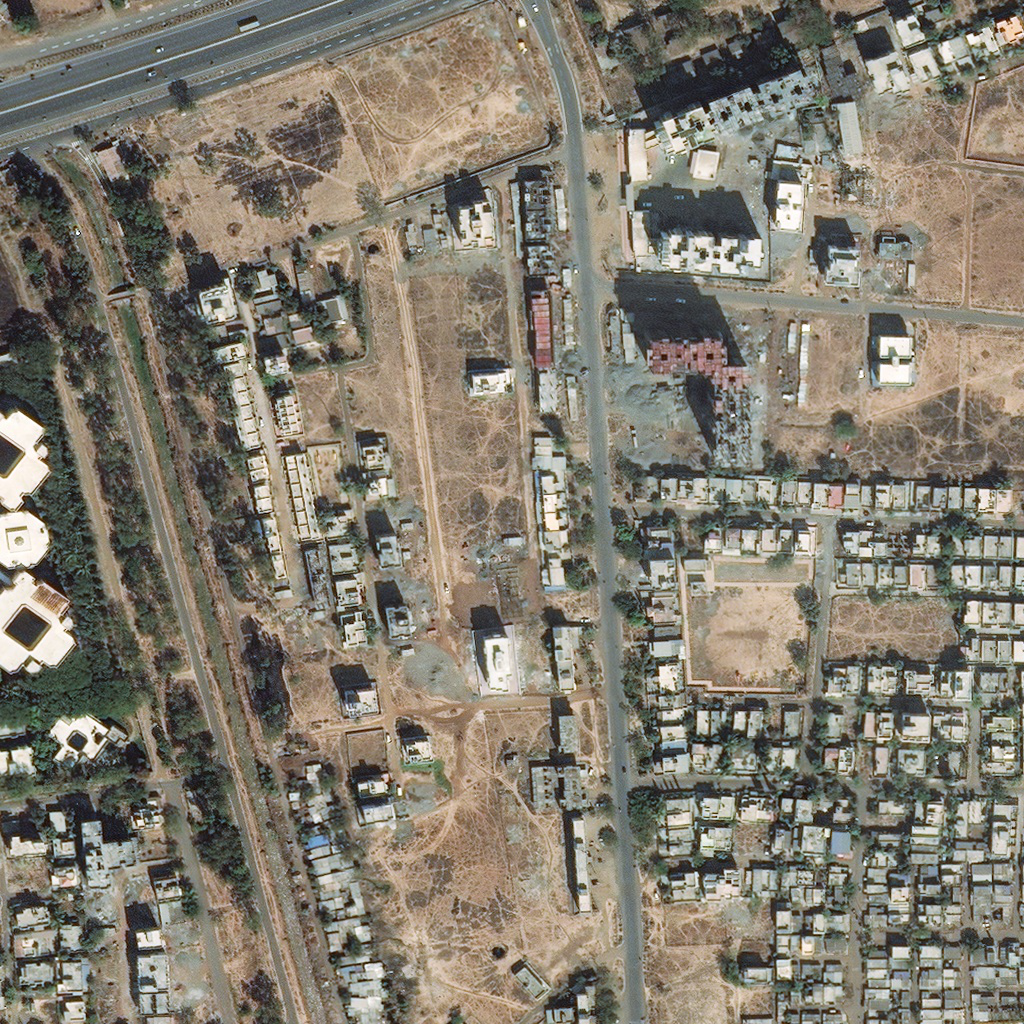

In [12]:
"""
Looks like train files are .jpg, while train masks are .png
Lets visualize a few images
"""

# Set seed
random.seed(41)

# 1. Get all image paths (* means "any combination")
image_path_list = list(train_path.glob("*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)
img = Image.open(random_image_path)

HEIGHT = img.height
WIDTH = img.width

print(random_image_path)
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

kaggle\train\486442_mask.png
Image height: 1024
Image width: 1024


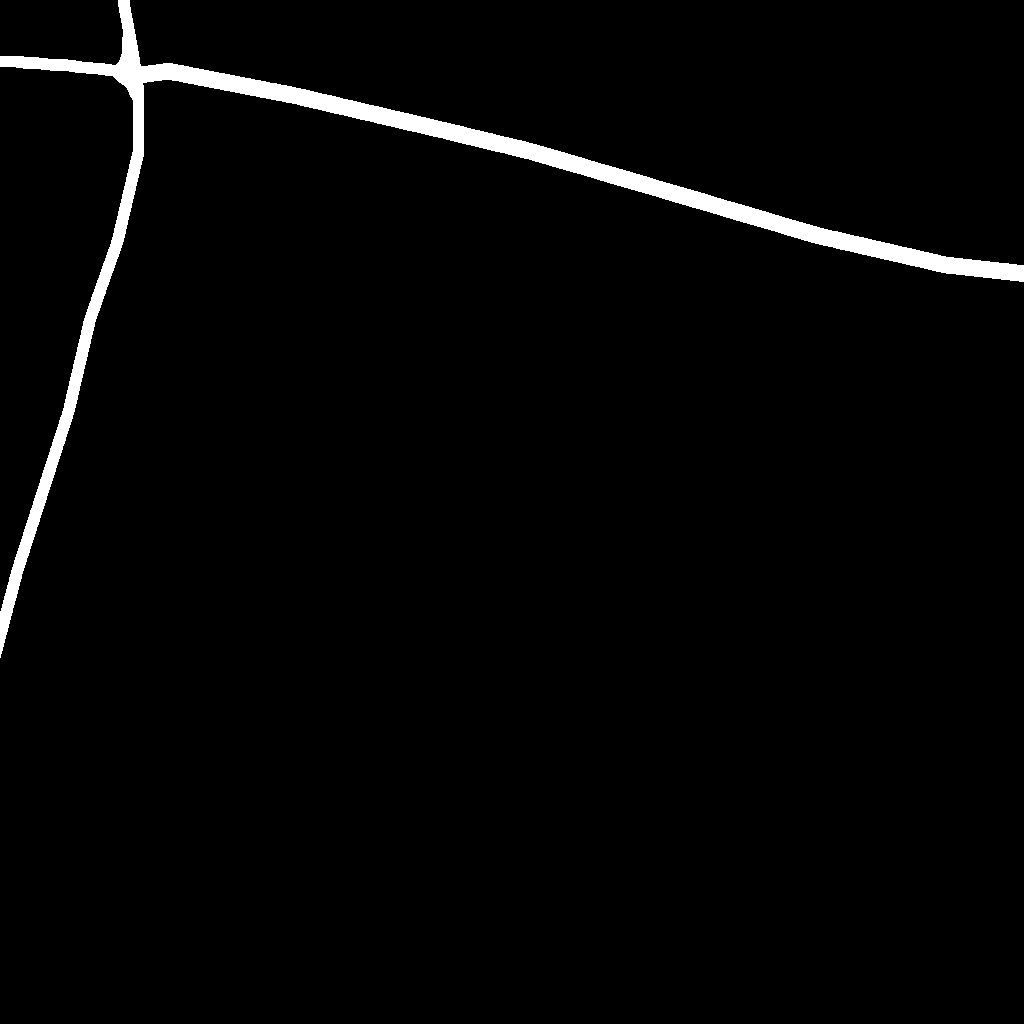

In [13]:
"""
Looks like train files are .jpg, while train masks are .png
Lets visualize a random mask
"""

# 1. Get all image paths (* means "any combination")
image_path_list = list(train_path.glob("*.png"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)
img_mask = Image.open(random_image_path)

print(random_image_path)
print(f"Image height: {img_mask.height}")
print(f"Image width: {img_mask.width}")
img_mask

In [14]:
val_image_count = len(metadata_val.image_id.unique())
val_path_list = list(val_path.glob("*.jpg"))

train_image_count = len(metadata_train.image_id.unique())
train_path_list = list(train_path.glob("*.jpg"))


def weight_calc(masks: torch.tensor , Batch_size:int):
    """
    Calculates the class imbalance in an image mask so that binary cross entropy loss
    can use the pos_wights parameter to weigh the roads higher than the background
    Args:
        masks: torch tensor, assumes dimension of input is [B,H,W]
        Batch_size, int. How many images to load at once for the weight calc. Pick a big batch size for this
    Output:
        pos_weights: torch tensor of size (1,) which weighs class 1 more/less than class 0 in the dataset
    """
    pos_weights = 0
    for mask_idx in range(Batch_size):
        zeros = (masks[mask_idx] == 0).sum()
        ones = (masks[mask_idx] == 1).sum()

        pos_weights+= zeros/ones
        
    return pos_weights/Batch_size #avg pos weight

In [80]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    

In [16]:
seed_everything(12)

Now time to create a custom dataset and dataloader that can read in our images

In [17]:
def mask_converter(mask):
    """
    This function takes in a mask and collapses the RGB channels so that
    the output dim is [1, H, W] 
    
    Args:
        mask: torch.tensor with shape [C = 3, H, W]
    Output:
        mask: tensor shape [C=1, H, W]
    """
    mask_sum = mask.sum(axis=0)
    return torch.where(mask_sum > 0., 1., 0.).unsqueeze(dim=0)

class RoadsDataSet(Dataset):
    
    #initialize target directory and transform parameters
    def __init__(self, targ_dir: str, img_transform=None, mask_transform=None) -> None:
        
        #create class attributes
        #get all image paths
        self.img_paths = list(Path(targ_dir).glob("*.jpg"))
        
        #now setup the transforms
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        
    #make a function to load an image and associated mask
    def load_img_and_mask(self, index: int):
        #Opens an image and mask and returns them
        image_path = self.img_paths[index]
        mask_path = image_path.__str__().replace("sat.jpg", "mask.png")
        
        return Image.open(image_path), Image.open(mask_path)   
    
    def __len__(self)-> int:
        """
        Returns the total number of satellite images
        Does not count masks
        """
        return len(self.img_paths) #list with image paths
    
    def __getitem__(self, index: int):
        """
        Returns one sample of image and mask
        """
        img, mask = self.load_img_and_mask(index)
        mask = self.mask_transform(mask)
        mask = mask_converter(mask)
        return self.img_transform(img), mask 
        
        

In [18]:
"""
make some transforms for the image processing pipeline.
I had previously calculated that this dataset has
R G B means: 0.4098297357559204, 0.3829575181007385, 0.28824561834335327 
and std devs: 0.12406449764966965, 0.009734021499752998, 0.007853982970118523
"""

#images are squares to start with
img_resize = int(HEIGHT / 4) #size 256x256

transformImg=T.Compose([
    T.Resize(size = (img_resize,img_resize), interpolation = T.InterpolationMode.BILINEAR, antialias=True), 
    T.ToTensor(),
    T.Normalize(mean  = [0.410, 0.383, 0.288] , std = [0.124, 0.009, 0.008])
    ])

transformMask=T.Compose([
    T.ToTensor(),
    T.Resize(size = (img_resize,img_resize), interpolation = T.InterpolationMode.NEAREST)
    ])        


In [19]:
train_data = RoadsDataSet(targ_dir = train_path.__str__(), img_transform=transformImg, mask_transform=transformMask)

print(f"the amount of images is {len(train_data)} with the same amount of masks")
print(f"the amount of images using pd.unique() is {train_image_count}, they should match")

the amount of images is 6226 with the same amount of masks
the amount of images using pd.unique() is 6226, they should match


In [81]:
def display_rand_images(dataset: torch.utils.data.dataset.Dataset, 
                       n: int = 3):
    """
    Displays n amount of random images and their associated masks
    Args:
        dataset: torch dataset
        n: int, default 3 images and masks to show
    Output: 
        matplotlib plots with nx2 total subplots
    """
    if n > 10:
        print('n too large, cutoff set to 10')
    else:
        random_samples_idx = random.sample(range(len(train_data)), k=n)
        
        plt.figure(figsize=(16,8))
        f, axarr = plt.subplots(n, 2)
        
        #loop through samples and plot images, masks
        for i, targ_sample in enumerate(random_samples_idx):
            targ_image, targ_mask = dataset[targ_sample][0], dataset[targ_sample][1]
            
            #return targ_image, targ_mask
            #now adjust images for plotting: [C, H, W] -> [H,W,C]
            targ_image_adjusted = targ_image.permute(1,2,0)
            targ_mask_adjusted = targ_mask.permute(1,2,0)
            
            axarr[i,0].imshow(targ_image_adjusted)
            axarr[i,1].imshow(targ_mask_adjusted)
            plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1600x800 with 0 Axes>

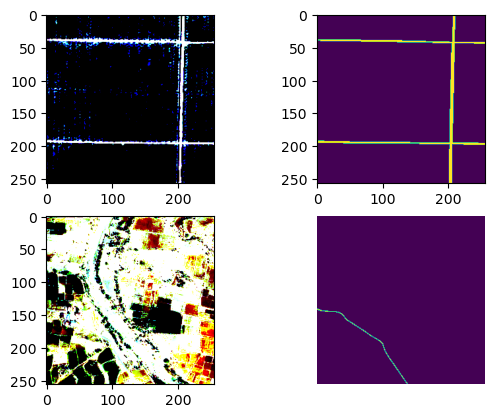

In [21]:
display_rand_images(train_data, n=2)

Now we will turn these custom loaded images into dataloaders

In [22]:
"""
Now we'll load images and masks and make sure they're the correct shape for input
the shape should be [B, C, H, W]
"""

train_dataloader = DataLoader(dataset = train_data,
                             batch_size = 8,
                             num_workers = 0,
                             shuffle = True)

img_sample, mask_sample = next(iter(train_dataloader))
print(f'Image shape is {img_sample.shape} and mask shape is {mask_sample.shape}')

Image shape is torch.Size([8, 3, 256, 256]) and mask shape is torch.Size([8, 1, 256, 256])


Now its time to load our neural net of choice from the pytorch model library and do some transfer learning


In [23]:
weights = torchvision.models.segmentation.FCN_ResNet101_Weights.DEFAULT
Net = torchvision.models.segmentation.fcn_resnet101(weights = weights)

In [24]:
"""
We only have 2 classes, need to replace the final layer of the downloaded NN
for our binary segmentation problem
"""
summary(Net, input_size = (8, 3, int(HEIGHT/2), int(WIDTH/2))) #assumed intput is Batch = 8, 3 channels, H and W

C:\Users\gumda\Anaconda3\envs\torch\Lib\site-packages\torchinfo\torchinfo.py:462: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type:depth-idx)                        Output Shape              Param #
FCN                                           [8, 21, 512, 512]         --
├─IntermediateLayerGetter: 1-1                [8, 2048, 64, 64]         --
│    └─Conv2d: 2-1                            [8, 64, 256, 256]         9,408
│    └─BatchNorm2d: 2-2                       [8, 64, 256, 256]         128
│    └─ReLU: 2-3                              [8, 64, 256, 256]         --
│    └─MaxPool2d: 2-4                         [8, 64, 128, 128]         --
│    └─Sequential: 2-5                        [8, 256, 128, 128]        --
│    │    └─Bottleneck: 3-1                   [8, 256, 128, 128]        75,008
│    │    └─Bottleneck: 3-2                   [8, 256, 128, 128]        70,400
│    │    └─Bottleneck: 3-3                   [8, 256, 128, 128]        70,400
│    └─Sequential: 2-6                        [8, 512, 64, 64]          --
│    │    └─Bottleneck: 3-4                   [8, 512, 64, 64]          379,392

In [25]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in Net.parameters():
    param.requires_grad = False

In [26]:
Net.classifier

FCNHead(
  (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(512, 21, kernel_size=(1, 1), stride=(1, 1))
)

In [27]:
#now change the classifier layer in the model
Net.classifier[4]  = torch.nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1)) #num_classes = 1 or 2 for binary?
Net.classifier

FCNHead(
  (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
)

----------------------------
Let's try a single forward pass on the model to make sure our process works

In [28]:
img, mask = next(iter(train_dataloader))
img_single = img[0].unsqueeze(dim=0)
mask_single = mask[0].unsqueeze(dim=0)

print(f"image shape is {img_single.shape} and mask shape is {mask_single.shape}")

#now do a single forward pass through the model
Net.to(device)
Net.eval()
with torch.inference_mode():
    pred = Net(img_single.to(device))['out']
    
print(f"output logits are \n {pred} \n")
print(f"output prediction probabilities are \n {torch.softmax(pred, dim = 1)}")

image shape is torch.Size([1, 3, 256, 256]) and mask shape is torch.Size([1, 1, 256, 256])
output logits are 
 tensor([[[[-0.0895, -0.0895, -0.0895,  ..., -0.0405, -0.0405, -0.0405],
          [-0.0895, -0.0895, -0.0895,  ..., -0.0405, -0.0405, -0.0405],
          [-0.0895, -0.0895, -0.0895,  ..., -0.0405, -0.0405, -0.0405],
          ...,
          [-0.0575, -0.0575, -0.0575,  ...,  0.0085,  0.0085,  0.0085],
          [-0.0575, -0.0575, -0.0575,  ...,  0.0085,  0.0085,  0.0085],
          [-0.0575, -0.0575, -0.0575,  ...,  0.0085,  0.0085,  0.0085]]]],
       device='cuda:0') 

output prediction probabilities are 
 tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]], device='cuda:0')


In [82]:
def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer):
    """
    Function that steps the model through a single iteration of training
    Args:
        model: torch.nn.Module, use the Net loaded above
        dataloader: torch.DataLoader, contains the dataloader for the training dataset
        loss_fn:torch.Module, using BCELoss with Logits for this project
        optimizer: torch.optim.Optimizer, using Adam for this project
    Output:
        train loss and train IoU, per epoch
    """
    
    #put model into train mode
    model.train()
    
    #set up train loss and iou values
    train_loss, train_iou = 0, 0
    
    #loop through dataloader batches
    for batch, (img, mask) in enumerate(dataloader):
        #send data to the target device
        img = img.to(device)
        mask = mask.to(device)
        
        #forward pass
        pred = model(img)['out']
        
        #calculate and accumulate loss
        loss = loss_fn(pred, mask)
        train_loss += loss.item()
        
        #zero the gradients
        optimizer.zero_grad()
        
        #loss backward
        loss.backward()
        
        #step the optimizer
        optimizer.step()
        
        #calculate and accumulate metrics across batches
        jaccard = JaccardIndex(task="binary", num_classes=2).to(device)
        train_iou += jaccard(pred, mask).detach().cpu()
        
    #adjust metrics to get average per batch
    train_loss = train_loss / len(dataloader)
    train_iou = train_iou / len(dataloader)
    return train_loss, train_iou

In [30]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.BCEWithLogitsLoss(),
          epochs: int = 2
         ):
    
    """
    This function takes in various training paramters and runs the train_step function
    to pass data through the model and calculate loss and IoU metrics
    Output:
        train loss (list) and train IoU (list) containing metrics for all epochs
    """
    
    train_loss = []
    train_iou = []
    
    #loop through training steps for a certain amount of epochs
    for epoch in tqdm(range(epochs)):
        tr_loss, tr_iou = train_step(model = model, dataloader = train_dataloader,
                                          loss_fn = loss_fn, optimizer = optimizer)
        
        
        print(f"Epoch {epoch} with loss {tr_loss} and IoU {tr_iou}")
            
        train_loss.append(tr_loss)
        train_iou.append(tr_iou)
    
    return train_loss, train_iou


def plot_loss_and_acc(epochs:int, lossvals:list , accvals:list, metric_name: str):
    """
    Create a helper function that plots loss over epochs and accuracy/IoU metrics over epochs
    args:
        epochs: int, number of epochs the model was trained
        lossvals: a lis of loss values per epoch
        accvals: a list of accuracy (or other metric) per epoch
        metric_name: the name of accuracy/IoU/precision/etc being used, type string
    output: 
        loss plot, acc/IoU/etc plot
    """
    
    epoch_list = np.arange(1, epochs + 1)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
    ax1.plot(epoch_list, lossvals)
    ax1.set_title('Loss')
    
    ax2.plot(epoch_list, accvals)
    ax2.set_title(metric_name)
    

In [83]:
# Lets calculate the pos weights parameter before progressing

big_batch = 100

sample_dataloader = DataLoader(dataset = train_data,
                             batch_size = big_batch,
                             num_workers = 0,
                             shuffle = False)

#set up the calculation for the pos_weights paramters in BCELoss

sample_imgs, sample_masks = next(iter(sample_dataloader))
posweights = weight_calc(sample_masks, Batch_size = big_batch) #roughly ~47 w/ batch size 16, ~54 w/ batch size 128 
print(f'The weight of class 1 is is now {posweights}')
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight= torch.round(posweights))

del sample_imgs
del sample_masks
del sample_dataloader

The weight of class 1 is is now 54.94700241088867


In [32]:
"""
Now define some parameters such as learning rate epoch, optimizer, etc
"""
learning_rate = 5e-4
BATCH_SIZE = 16
EPOCHS = 14

optimizer = torch.optim.Adam(params = Net.parameters(), lr = learning_rate)

train_dataloader = DataLoader(dataset = train_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 0,
                             shuffle = False)

In [33]:
%%time

#now train the thing
    
loss, iou = train(model = Net, train_dataloader = train_dataloader, 
                 optimizer = optimizer, loss_fn = loss_fn, epochs = EPOCHS)

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 0 with loss 1.8553668000759223 and IoU 0.046551115810871124
Epoch 1 with loss 1.7612194134638859 and IoU 0.053584251552820206
Epoch 2 with loss 1.7330275832078397 and IoU 0.055809151381254196
Epoch 3 with loss 1.7131733227998782 and IoU 0.057265497744083405
Epoch 4 with loss 1.697928165166806 and IoU 0.05840455740690231
Epoch 5 with loss 1.685910746990106 and IoU 0.05934979394078255
Epoch 6 with loss 1.676436114922548 and IoU 0.06012273579835892
Epoch 7 with loss 1.668368233472873 and IoU 0.06080654263496399
Epoch 8 with loss 1.6618956281588628 and IoU 0.061398696154356
Epoch 9 with loss 1.656519799049084 and IoU 0.06187506020069122
Epoch 10 with loss 1.6517986707198313 and IoU 0.06230727583169937
Epoch 11 with loss 1.6479979255260566 and IoU 0.06269590556621552
Epoch 12 with loss 1.644643724270356 and IoU 0.06304465234279633
Epoch 13 with loss 1.641765332221985 and IoU 0.06332315504550934
CPU times: total: 9h 49min 8s
Wall time: 3h 8min 52s


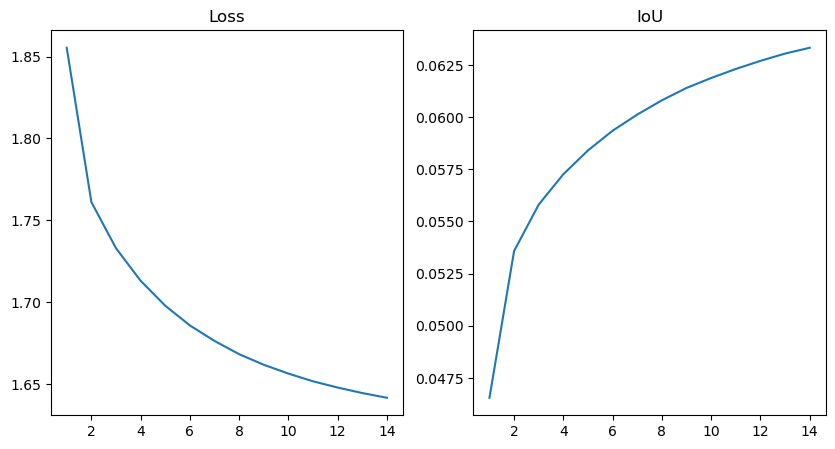

In [34]:
plot_loss_and_acc(epochs=EPOCHS, lossvals=loss , accvals=iou, metric_name = 'IoU' )

In [85]:
#lets make functions to pass a prediction through the NN and see what the mask looks like

def check_image(Model:torch.nn.Module, 
                tr_dataloader:torch.utils.data.DataLoader, 
                batch_size:int):
    """
    Runs a test image through the model, predicts a mask
    Args:
        Model: use the trained Net above
        tr_dataloader: the train dataloader,
        batch_size: int, can use what was used for training
    Output:
        image, mask, predictions of shape [B, C, H, W]
    """
    Model.to(device)
    Model.eval()
    
    img, mask = next(iter(tr_dataloader))
    random_idx = np.random.randint(batch_size)
    
    img_single = img[random_idx].unsqueeze(dim=0)
    mask_single = mask[random_idx].unsqueeze(dim=0)

    #now run the model without gradients
    with torch.no_grad():
        
        y_pred = Model(img_single.to(device))['out'] #create logit prediction
        
        y_pred = y_pred.squeeze(dim=0).cpu()
        siggy = torch.nn.Sigmoid()
        predicted_mask = siggy(y_pred) #change into probabilities
        
        #resturns all tensors with shape [B, C, H, W]
        return img_single, mask_single, y_pred.unsqueeze(dim=0)
        

def plot_3images(img, mask, pred):
    """
    Plots the 3 images: image, mask, prediction side by side
    """
    
    n_images = 3
    img_list = [img, mask, pred]
    img_list_converted = [obj.squeeze(dim=0).permute(1,2,0) for obj in img_list]
    
    plt.figure(figsize=(20,8))
    for idx in range(n_images):
        plt.subplot(1, n_images, idx+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img_list_converted[idx])
    plt.show()
    

In [78]:
testim, testmask, testresult = check_image(Net, train_dataloader, batch_size = BATCH_SIZE)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


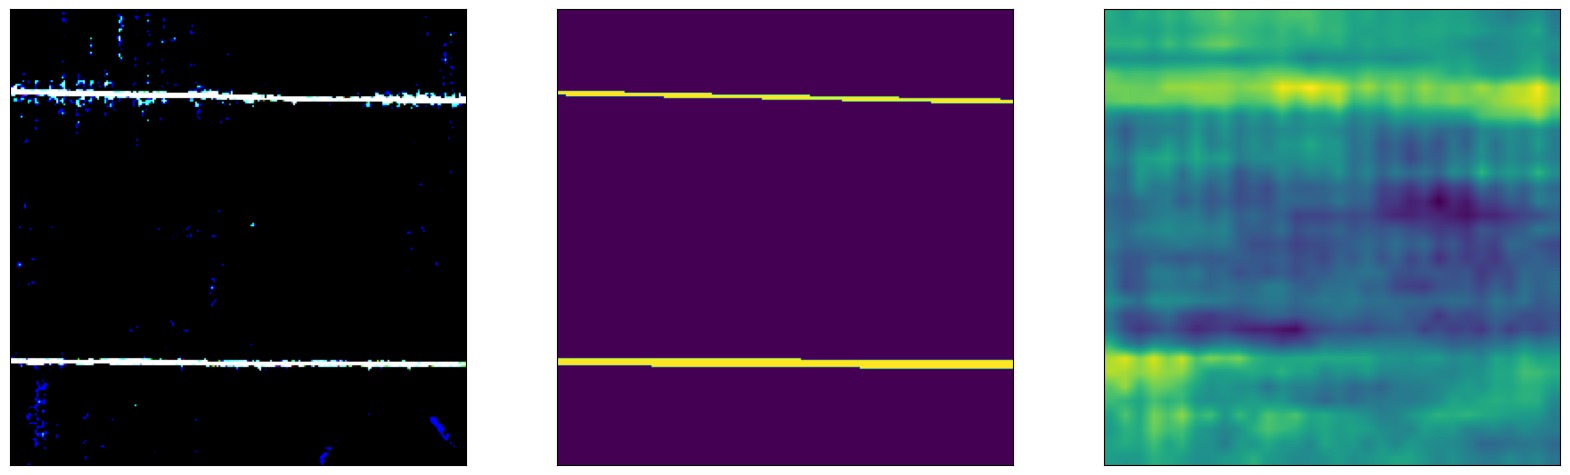

In [79]:
plot_3images(testim, testmask, testresult)

Looks like the segmentation process is working on simple inputs. Without a proper validation that has image masks it can be hard to judge when we enter an overfitting regime, so next steps would be to try one of several things:  
- split the training set into 80% train and 20% validation, report those metrics during training as well
- change the loss function from BCEWithLogits to Dice Loss
- Add image augmentations to the dataset class
- Add a learning rate scheduler
- Add early stopping